## Plot vanMises

Mises distr and sampels

In [1]:
# von Mises distribution, one dimensional

# Modified Bessel function of the first kind of order 0. Note: there is a difference between normal and modified Bessel function.
from scipy.special import i0
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import torch

import matplotlib
# matplotlib.use('Qt5Agg')

# make the plots inline again
%matplotlib inline

mu = 0
k = 4
tau = 2*np.pi


def van_Mises_density(x,mu,k):
    """
    Args: 
        x: np.array
        mu,k scalar parameters
    return:
        np.array
    """
    return np.array([ np.exp(k*np.cos(xi-mu))/(tau*i0(k)) for xi in x ])

def plot_van_Mises(k,mu):
    rcParams['figure.figsize'] = 15, 7

    x = np.linspace(-np.pi, np.pi, 1000)
    y = van_Mises_density(x,mu,k)

    fig, ax = plt.subplots(1)

    ax.plot(x, y)
    # ax.set_aspect(1)

    # plt.xlim(-0.25,tau+0.25)
    plt.xlim(-0.25-np.pi,np.pi+0.25)
    plt.ylim(-0.1,1)

    plt.grid(linestyle='--')

    plt.title('Van Mises density', fontsize=15)

    plt.show()

def plot_samples(y):
    x = np.linspace(-np.pi, np.pi, len(y))

    fig, ax = plt.subplots(1)

    ax.plot(x, y)
    
    plt.xlim(-0.25-np.pi,np.pi+0.25)
    plt.ylim(-0.1,1)

    plt.grid(linestyle='--')

    plt.title('Samples', fontsize=15)

    plt.show()
    
def plot_hist(s,bins = 30):

    plt.xlim(-0.25-np.pi,np.pi+0.25)
    plt.grid(linestyle='--')
    plt.title('Histogram of samples', fontsize=15)
    plt.hist(s,bins = bins, color = 'blue', edgecolor = 'black',)
    
from random import random

def plot_mixture_van_Mises(nr_mixtures):
    
    rcParams['figure.figsize'] = 15, 7
    fig, ax = plt.subplots(1)

    x = np.linspace(-np.pi, np.pi, 1000)
    y=0
    params = []
    for i in range(nr_mixtures):
        mu = (2*np.pi*random()-np.pi)
        k = random()*20
        params.append([mu,k])
        y += 1/nr_mixtures*van_Mises_density(x,mu,k)
        ax.scatter(mu,0, s=10,marker = 'x',color ='red')

    print(params)
    ax.plot(x, y)
    # ax.set_aspect(1)

    # plt.xlim(-0.25,tau+0.25)
    plt.xlim(-0.25-np.pi,np.pi+0.25)
#     plt.ylim(-0.1,1)

    plt.grid(linestyle='--')

    plt.title(f'Van Mises mixture density', fontsize=15)

    plt.show()


## Möbius transformation functions

In numpy version that allows for 'batch' sizes and pytorch version with autograd

In [2]:
from numpy.linalg import norm




def h_moebius_transform(x,w,rotate_back=False):
    """
    The prefix h indicates that a vector \in R^D is returned. So we interpret the sphere as embedded in the Euclidean space.
    Args:
        x: np array of shape (nr_samples,n_dim)
        w: np.array of shape (n_dim)
        rotate_back: boolean indicates if rotation matrix rotates h(1,0) back to (1,0)
    Return:
        np.array of shape (nr_samples,n_dim)
    """
    def h(z):
        r = 1
        return (r**2 - norm(w)**2)/(norm(z-w)**2)*(z-w)-w
    
    def get_rotate_back_matrix():
        # calculate image of point (1,0), which corresponds to theta = 0
        h_10 = h(np.array([1,0]))
        # get corresponding angle
        theta_10 = np.arctan2(h_10[1], h_10[0])
        # get rotation matrix that rotates h(1,0) back to (1,0)
        cos = np.cos(-theta_10)
        sin = np.sin(-theta_10)
        R = np.array(
                    [[cos, -sin], 
                     [sin, cos]]
                    )
        return R
    
#     print('check for bisection', x )
#     print('type of x', type(x) )
#     print('shape', x.shape )

    h_image = np.apply_along_axis(func1d = h, axis = 1, arr = x)

    if rotate_back:
        
        R = get_rotate_back_matrix()
        
        return np.dot(R,h_image.T).T
    else:
        return h_image
    
def f_moebius_transform(theta0,w,rotate_back = False):     
    """
    Same function as h_moebius_transform just that it is a function from [0,2pi] -> [0,2pi] instead of R^2 -> R^2
    Args: 
        theta0: np.array of shape (nr_samples,dim)
    """
    # Bisection method inputs floats but function expects numpy arrays. 
    if not isinstance(theta0,np.ndarray):
        theta0 = np.array([theta0])
    
    r = 1.0
#     print('check for bisection theta0',theta0)
#     print('type of theta0', type(theta0) )
#     print('shape', theta0.shape )
    
    x1_trafo = r*np.cos(theta0)
    x2_trafo = r*np.sin(theta0)
    
#     print('check for bisection x1_trafo',x1_trafo)
#     print('type of x1_trafo', type(x1_trafo))
#     print('shape', x1_trafo.shape )

    x = np.array([x1_trafo,x2_trafo]).T
    
    h = h_moebius_transform(x, w, rotate_back=rotate_back)

    # NOTE: VERY IMPORTANT. We have to add a rounding here. Otherwise theta = 0 is not going to be a perfect fixpoint, 
    # which causes issues when taking convex combinations of Möbius transformations 
    theta = np.round(np.arctan2(h[:,1],h[:,0]),decimals = 7) % (2*np.pi)  
    
    return theta
    
    

import math

def h_moebius_transform_torch(x,w,rotate_back=False):
    """
    Torch implementation of the func h_moebius transform. Key difference is that it only allows for scalar input and returns.
    
    The prefix h indicates that a vector \in R^D is returned. So we interpret the sphere as embedded in the Euclidean space.
    Args:
        x: torch.tensor of shape (n_dim)
        w: torch.tensor of shape (n_dim)
        rotate_back: boolean indicates if rotation matrix rotates h(1,0) back to (1,0)
    Return:
        torch.tensor of shape (nr_samples,n_dim)
    """
    def h(z):
        return (1 - torch.norm(w,p=2)**2)/(torch.norm(z-w,p=2)**2)*(z-w)-w
    
    def get_rotate_back_matrix():
        
        # calculate image of point (1,0), which corresponds to theta = 0
        h_10 = h(torch.tensor([1,0]))
        # get corresponding angle 
        theta_10 = torch.atan2(h_10[1],h_10[0])

        # get rotation matrix that rotates h(1,0) back to (1,0)
        cos = torch.cos(-theta_10)
        sin = torch.sin(-theta_10)
        R = torch.tensor(
                    [[cos, -sin], 
                     [sin, cos]]
                    )
        return R
    
    # get dimensionality of data, should be mostly == 2
    n_dim = x.shape[0]
    
    h_image = h(x)

    if rotate_back:
        R = get_rotate_back_matrix()   
        # transform first h_image into R^{2x1} vector for proper matrix multiplication and transform R*h_image back to row vector of shape 1x2
#         print('h before rotation',h_image)
        rotated_h = torch.mm(R,h_image.view(2,1)).view(2)
#         print('h afte rotation',torch.mm(R,h_image.view(2,1)))
#         print(R)
        return rotated_h
    
    else:
        return h_image
    
def f_moebius_transform_torch(theta0,w,rotate_back = False):     
    """
    Args: 
        theta0: 0 dimensional torch tensor. shape = torch.size([])
        w:      2 dimensional torch tensor. shape = torch.size([2])
    Same function as h_moebius_transform just that it is a function from [0,2pi] -> [0,2pi] instead of R^2 -> R^2
    """
    r = 1
    x1_trafo = r*torch.cos(theta0)
    x2_trafo = r*torch.sin(theta0)

    x = torch.stack([x1_trafo,x2_trafo])
    h = h_moebius_transform_torch(x,w,rotate_back=rotate_back)
    
    # NOTE: IMPORTANT: We round here with our own round function to ensures that, theta = 0 is a real fixpoint of the transformation. 
    # Otherwise we could have f(0) = 2pi-epsilon 
    # This 2pi - epsilon value, which is actually close to one, would add up to something not equal 0 in our convex combination
    
    # init rounding function     
    rounding = rounding_STG.apply
    nr_decimals = 7
    
    # NOTE: mod 2pi change output of arctan2 from [-pi,pi] to [pi,pi]
#     theta = torch.atan2(h[1],h[0]) % (2*math.pi) 
#     theta = rounding(torch.atan2(h[1],h[0]),nr_decimals) % (2*math.pi) 
    theta = rounding(torch.atan2(h[1],h[0]),nr_decimals) % (2*math.pi)     

    return theta

def get_angle_of_rotation(w):
    def h(z):
        return (1 - norm(w)**2)/(norm(z-w)**2)*(z-w)-w
    h_10 = h(np.array([1,0]))
    # get corresponding angle
    theta_10 = np.arctan2(h_10[1],h_10[0]) 
    return theta_10




In [3]:
import torch

class rounding_STG(torch.autograd.Function):
    """
    Differentiable way of roundingg with given decimals. 
    
    Uses straigth-trough estimator to calculate a gradient. Gradient is set to 1.
    """
    
    @staticmethod
    def forward(ctx, input, decimals):
        # ctx.save_for_backward(input)
        out = torch.round(input*(10**decimals))/(10**decimals)
        return out

    @staticmethod
    def backward(ctx,grad_output):
        # result, = ctx.saved_tensors
        gradient = torch.tensor([1.0])
        
        # Question: why do I have to return None here??
        
        # NOTE: grad_output is the previous gradient. 
        # So gradient * grad_output enures if you do 1/3*rouding(x), that 1/3 is returned as grad and not const = 1
        
        return gradient * grad_output, None



## Möbius transformation of equidistant points

In [4]:
rcParams['figure.figsize'] = 7, 7

def plot_moebius_transform_just_circle(w,rotate_back = False):
    
    nr_points = 80
    
    plt.figure(1)
    # Plot circle
    theta = np.linspace(0, 2*np.pi, 100)
    r = 1
    x1 = r*np.cos(theta)
    x2 = r*np.sin(theta)
    plt.plot(x1, x2,color ='black',alpha = 0.1)

    # plot equidistant points on circle
    theta = np.linspace(0, 2*np.pi, nr_points)
    x1s = r*np.cos(theta)
    x2s = r*np.sin(theta)
    plt.scatter(x1s, x2s,s= 10, color ='black',alpha = 1)

    # plot parameter point
    plt.scatter(w[0],w[1],s= 10, color ='blue',alpha = 1)

    # plot möbius transform
    x = np.array([x1s,x2s]).T
    h = h_moebius_transform(x, w, rotate_back = rotate_back)
    h1 = h[:,0]
    h2 = h[:,1]
    
    plt.scatter(h1, h2,s= 10, color ='red',alpha = 1)

    plt.grid(linestyle='--')
    plt.title(f'Möbius transformation with center {w} of {nr_points} equidistant points with rotate_back: {rotate_back}')
    plt.title(f'Möbius transformation with center {w}')
    plt.show()
    
    



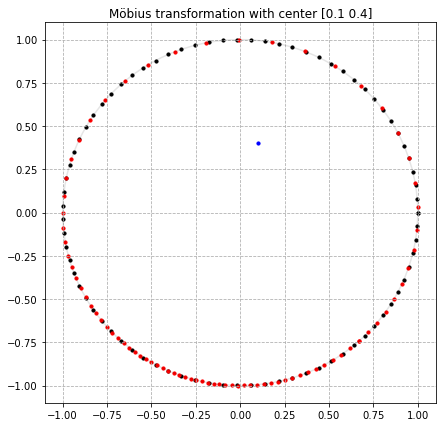

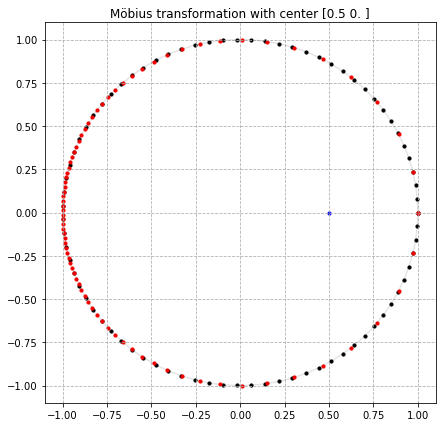

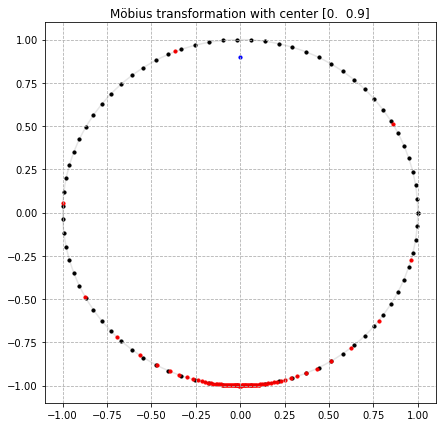

In [5]:
w = np.array([0.1,0.4])
plot_moebius_transform_just_circle(w)

w = np.array([0.5,0])
plot_moebius_transform_just_circle(w)

w = np.array([0,0.9])
plot_moebius_transform_just_circle(w)

In [6]:
from tqdm import tqdm    
import matplotlib.ticker as tck

def plot_moebius_transform(w,rotate_back = True, plot_name=None):
  
    nr_points = 50

    fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3,  figsize=(19,5))

    # PLOT 1: circle plot
    theta = np.linspace(0, 2*np.pi, 100)
    r = np.sqrt(1.0)
    x1 = r*np.cos(theta)
    x2 = r*np.sin(theta)
    ax1.plot(x1, x2,color ='black',alpha = 0.1)

    # plot equidistant points on circle
    theta = np.linspace(0, 2*np.pi, nr_points)
    x1s = r*np.cos(theta)
    x2s = r*np.sin(theta)
    ax1.scatter(x1s, x2s,s= 5, color ='black',alpha = 1)

    # plot parameter point
    ax1.scatter(w[0],w[1], s= 20, color ='blue',alpha = 1)

    # plot möbius transform on circle
    x = np.array([x1s,x2s]).T
    h = h_moebius_transform(x,w,rotate_back = rotate_back)
    h1 = h[:,0]
    h2 = h[:,1]
    ax1.scatter(h1, h2,s= 5, color ='red',alpha = 1)

    ax1.grid(linestyle='--')
    ax1.title.set_text(f'Möbius Transformation \n with Center {w} of {nr_points} Equidistant Points \n Fixed Point = {rotate_back}')

    # PLOT 2: 
    # Möbius transformation of the interval [0,2pi] plot
    theta0 = np.linspace(0, 2*np.pi, 1000)    
    f_theta = f_moebius_transform(theta0, w, rotate_back=rotate_back)    

    ax2.scatter(theta0/np.pi,f_theta/np.pi,s=1)
    ax2.grid(linestyle='--')
    ax2.title.set_text(f'Moebius Transformation of [0,2$\pi$]')
    
    ax1.set(aspect='equal')
    ax2.set(aspect='equal')    
    
    # PLOT 3
    # Density plots
    theta0s = torch.tensor(theta0, requires_grad=True)
    
    rotation_theta = get_angle_of_rotation(w)
    
    w = torch.tensor(w)
    i =0 
    for theta in tqdm(theta0s):
        f_theta_torch = f_moebius_transform_torch(theta, w, rotate_back=rotate_back)

        f_theta_torch.backward()
        if i ==0:
            print(f_theta_torch)
        i= i+1
    Jacobian_f = theta0s.grad.detach().numpy()

    dtheta = theta0[1]-theta0[0]
    
    # change of variables formula: 
    #    p(x) = p_0(f^{-1}(x)) / J_f(theta) = p_0(f^{-1}(x)) / J_f(f^{-1}(x))
    # or p(f(theta)) = p_0 (theta) / J_f(theta)
    from matplotlib.lines import Line2D
    
    ax3.scatter((f_theta/np.pi), 1/(2*np.pi*Jacobian_f), s=2)

#     ax3.plot( theta0/np.pi  , [1/(2*np.pi) for _ in range(len(theta0))] , linewidth=2,color = 'grey')
    
#     legend_elements = [Line2D([0], [0], color='b',label = 'Moebius Distr.')]

#     ax3.legend(handles=legend_elements,loc = 'upper left')

    
    ax3.grid(linestyle='--')
    ax3.title.set_text(f'Prob. Density of Moebius Transformation')
                
    # Check integral of densities numerically, is not one at the moment o_(O) . But plot looks okay
#     print('integral',scipy.integrate.simps(f_theta, 1/(2*np.pi*Jacobian_f )))
#     print('integral w/o x',scipy.integrate.simps(1/(2*np.pi*Jacobian_f ))) 
#     print('integral uniform',scipy.integrate.simps( theta0/np.pi  , [1/(2*np.pi) for _ in range(len(theta0))] ) ) 
    
    ax1.set(aspect='equal')

    
    # add ticks at multiples of pie
    ax2.xaxis.set_major_formatter(tck.FormatStrFormatter('%g $\pi$'))
    ax2.xaxis.set_major_locator(tck.MultipleLocator(base=1/2))

    ax2.yaxis.set_major_formatter(tck.FormatStrFormatter('%g $\pi$'))
    ax2.yaxis.set_major_locator(tck.MultipleLocator(base=1/2))
    
    ax3.xaxis.set_major_formatter(tck.FormatStrFormatter('%g $\pi$'))
    ax3.xaxis.set_major_locator(tck.MultipleLocator(base=1/2))
    
    if plot_name is not None:
        path = 'moeb_plot/'
        plt.savefig(path + f"{plot_name}.svg",format='svg')
    plt.show()



## Fixed center

### With rotation back

 15%|█▍        | 149/1000 [00:00<00:01, 740.73it/s]

tensor(0., dtype=torch.float64, grad_fn=<RemainderBackward0>)


100%|██████████| 1000/1000 [00:01<00:00, 794.47it/s]


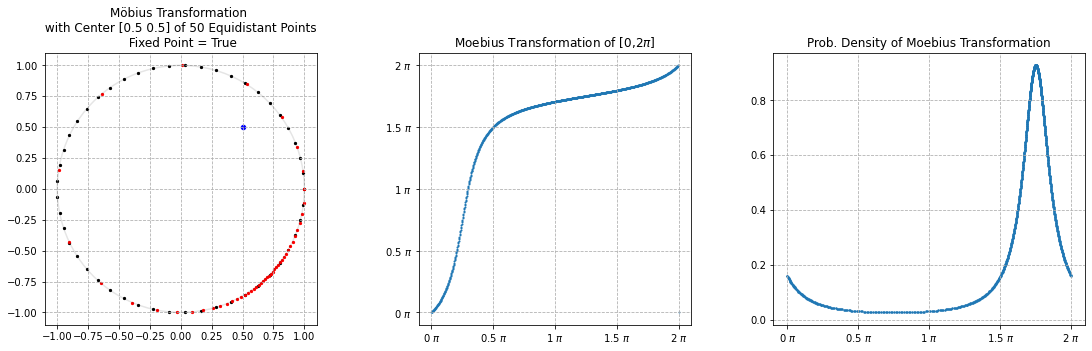

In [7]:

rotate_back = True

w = np.array([0.5,0.5])
plot_moebius_transform(w,rotate_back = rotate_back, plot_name='Moeb_w_fix')

# w = np.array([0.5,0])
# plot_moebius_transform(w,rotate_back = rotate_back)

# w = np.array([0,0.9])
# plot_moebius_transform(w,rotate_back = rotate_back)

# w = np.array([0.25,0.66])
# plot_moebius_transform(w,rotate_back = rotate_back)



## Without rotation back

 21%|██        | 208/1000 [00:00<00:00, 987.82it/s]

tensor(4.7124, dtype=torch.float64, grad_fn=<RemainderBackward0>)


100%|██████████| 1000/1000 [00:01<00:00, 973.29it/s]


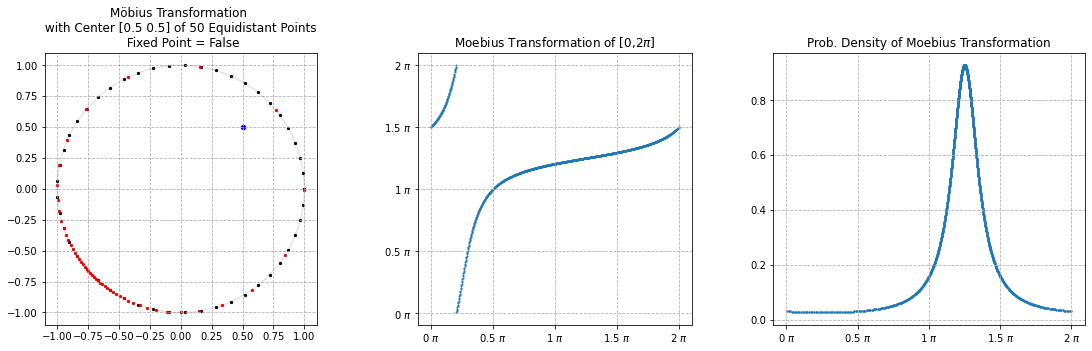

In [8]:

rotate_back = False

w = np.array([0.5,0.5])
plot_moebius_transform(w,rotate_back = rotate_back, plot_name='Moeb_wo_fix')

# w = np.array([0.5,0])
# plot_moebius_transform(w,rotate_back = rotate_back)

# w = np.array([0,0.9])
# plot_moebius_transform(w,rotate_back = rotate_back)

# w = np.array([0.25,0.66])
# plot_moebius_transform(w,rotate_back = rotate_back)


## Plot with moving projection centers

In [9]:
# from random import random
# # from random import random
# for index in range(10):
#     phi = random()*2*np.pi
#     r0 = random()*(0.95-0.1)+0.1
#     w1 = r0*np.cos(phi)
#     w2 = r0*np.sin(phi)

#     w = np.array([index*(-1)/5,0])
#     # print(w)
#     #w = np.array([0.08232022, -0.92001225])
#     plot_moebius_transform(w,rotate_back = False)

## convex combination

In [10]:
def f_convex_moebius_transform(theta,w,rho,rotate_back=True):
    
    """
    The prefix h indicates that a vector \in R^D is returned. So we interpret the sphere as embedded in the Euclidean space.
    Args:
        x: np array of shape (nr_samples,n_dim)
        w: np.array of shape (K_m, nr_dim) , where K_m is number of centers and thus the number of summands in convex combination.
            we stick to Rezende 2020 notation.
        rho: np.array of shape (K_m, )
    Return:
        angle: np.array of shape (nr_samples,n_dim)
               returns an angle of f(theta) = \sum_i f_i(theta)
    """
    assert rho.shape[0] == w.shape[0], "Number of centers (in w) must be equal to number of weights in convex combination"
    
    # normalize rho
    rho = rho/np.sum(rho)
    
    f_theta = 0 

    for idx, center in enumerate(w):
        f_theta += rho[idx]*f_moebius_transform(theta,center,rotate_back = rotate_back) 
    return f_theta 
        
    
def f_convex_moebius_transform_torch(theta,w,rho,rotate_back=True):
    
    """
    The prefix h indicates that a vector \in R^D is returned. So we interpret the sphere as embedded in the Euclidean space.
    
    Args:
        theta: torch.tensor of shape (n_dim)
        w: torch.tensor / np.array of shape (K_m, nr_dim) , where K_m is number of centers and thus the number of summands in convex combination.
           we stick to Rezende 2020 notation.
        rho: torch.tensor / np.array of shape (K_m, )
        
    Return:
        angle: torch.tensor of shape (nr_samples,n_dim) ; returns an angle of f(theta) = \sum_i f_i(theta)
               
    """
    assert rho.shape[0] == w.shape[0], "Number of centers (in w) must be equal to number of weights in convex combination"
    
    # normalize rho
    rho = rho/np.sum(rho)
    
    f_theta = 0 

    for idx, center in enumerate(w):
        
        f_theta += rho[idx] * f_moebius_transform_torch(theta, center, rotate_back = rotate_back)
        
    return f_theta 
        
    
def plot_convex_moebius_transform(w, rho, rotate_back=False, plot_name=None):
    """
        Args: list of centers of shape (K_m, nr_dim)
        
        Return: plots
    """
    nr_points = 40
    
    fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3,  figsize=(19, 5))
     
    # Plot circle
    theta = np.linspace(0, 2*np.pi, 100)
    r = np.sqrt(1.0)
    x1 = r*np.cos(theta)
    x2 = r*np.sin(theta)
    ax1.plot(x1, x2,color ='black',alpha = 0.1)

    # plot equidistant points on circle
    theta = np.linspace(0, 2*np.pi, nr_points)
    x1s = r*np.cos(theta)
    x2s = r*np.sin(theta)
    ax1.scatter(x1s, x2s,s= 10, color ='black',alpha = 1)

    # plot parameter points
    for center in w:
        ax1.scatter(center[0],center[1],s= 20, color ='blue',alpha = 1)
        
    # plot möbius transform
    theta = f_convex_moebius_transform(theta,w,rho,rotate_back=rotate_back)
    
    r = np.sqrt(1.0)
    x1 = r*np.cos(theta)
    x2 = r*np.sin(theta)

    ax1.scatter(x1, x2,s= 10, color ='red',alpha = 1)

    ax1.grid(linestyle='--')
    ax1.title.set_text(f'Möbius Transformation with Center \n {w} \n and Fixed Point: {rotate_back}')
    
    # PLOT 2: 
    # Möbius transformation of the interval [0,2pi] plot
    theta0 = np.linspace(0, 2*np.pi, 1000)
    f_theta = f_convex_moebius_transform(theta0,w,rho,rotate_back=rotate_back) 
    
    ax2.scatter(theta0/np.pi,f_theta/np.pi,s=2)
    ax2.grid(linestyle='--')
    ax2.title.set_text(f'Moebius Transformation of [0,2$\pi$]')
    
    ax1.set(aspect='equal')
    ax2.set(aspect='equal')
    
    
    # PLOT 3 - density update
    # Density plotstd
    theta0s = torch.tensor(theta0, requires_grad=True)
    
    w = torch.tensor(w)
    nr_transformations = w.shape[0]
    rho = np.ones(nr_transformations)
    
    i = 0 
    for theta in tqdm(theta0s):
        f_theta_torch = f_convex_moebius_transform_torch(theta,w,rho=rho,rotate_back=rotate_back)
        if i ==0:
            print('first theta',f_theta_torch)
        if i == (len(theta0s)-1):
            print('last theta',f_theta_torch)
        i = i +1
        f_theta_torch.backward()
#     print(theta0s.grad)
    Jacobian_f = theta0s.grad.detach().numpy()
    
#     print(Jacobian_f)
    
    # change of variables formula: 
    #    p(x) = p_0(f^{-1}(x)) * J_f^{-1}(theta)
    # or p(f(theta)) = p_0 (theta) / J_(theta) ! We use this version, because we can not analytically obtain f^{-1} in the convex case
    
    ax3.scatter( f_theta/np.pi, 1/(2*np.pi*Jacobian_f) , s = 2)   
    ax3.set_xlim(-0.065, 2.065)
    ax2.set_ylim(-0.075, 2.075)
#     ax3.plot( theta0/np.pi  , [1/(2*np.pi) for _ in range(len(theta0))]  ,linewidth=2,color = 'grey')
                
    ax3.grid(linestyle='--')
    ax3.title.set_text(f'Prob. Density of Moebius Transformation')
    matplotlib.use('SVG')
    
    # add ticks at multiples of pie
    ax2.xaxis.set_major_formatter(tck.FormatStrFormatter('%g $\pi$'))
    ax2.xaxis.set_major_locator(tck.MultipleLocator(base=1/2))

    ax2.yaxis.set_major_formatter(tck.FormatStrFormatter('%g $\pi$'))
    ax2.yaxis.set_major_locator(tck.MultipleLocator(base=1/2))
    
    ax3.xaxis.set_major_formatter(tck.FormatStrFormatter('%g $\pi$'))
    ax3.xaxis.set_major_locator(tck.MultipleLocator(base=1/2))      

    if plot_name is not None:
        path = 'moeb_plot/'
        fig.savefig(path + f"{plot_name}.svg",format='svg')
    
    plt.show()

## Convex combination

  9%|▊         | 87/1000 [00:00<00:02, 433.12it/s]

first theta tensor(0., dtype=torch.float64, grad_fn=<AddBackward0>)


100%|██████████| 1000/1000 [00:02<00:00, 423.93it/s]


last theta tensor(0., dtype=torch.float64, grad_fn=<AddBackward0>)


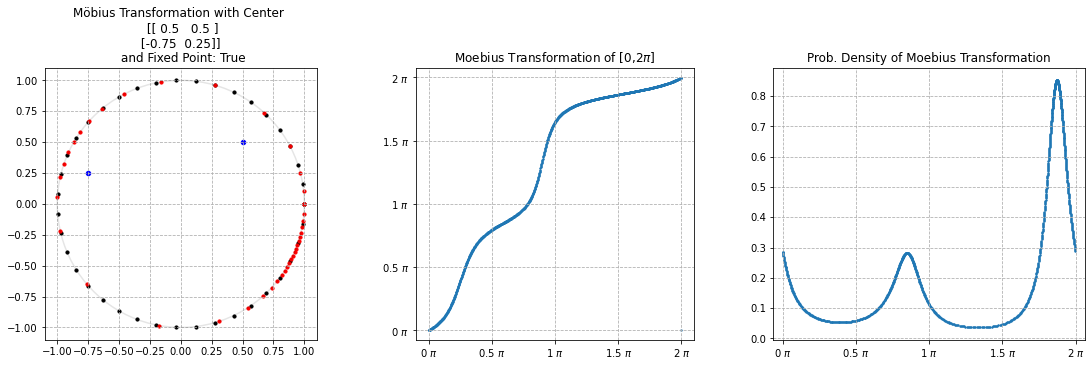

In [13]:
w1 = np.array([0.5,0.5])
w2 = np.array([0.75,0])
w3 = np.array([0,0.9])
w4 = np.array([-0.5,-0.5])
w5 = np.array([-0.75,0.25])

w = np.array([w1,w2,w3,w4,w5])

w = np.array([w1,w5])


rho = np.ones(w.shape[0])

plot_convex_moebius_transform(w,rho=rho ,rotate_back=True, plot_name='Moeb_convex_w_fix')


 11%|█         | 106/1000 [00:00<00:01, 530.27it/s]

first theta tensor(5.3559, dtype=torch.float64, grad_fn=<AddBackward0>)


100%|██████████| 1000/1000 [00:01<00:00, 517.82it/s]


last theta tensor(5.3559, dtype=torch.float64, grad_fn=<AddBackward0>)


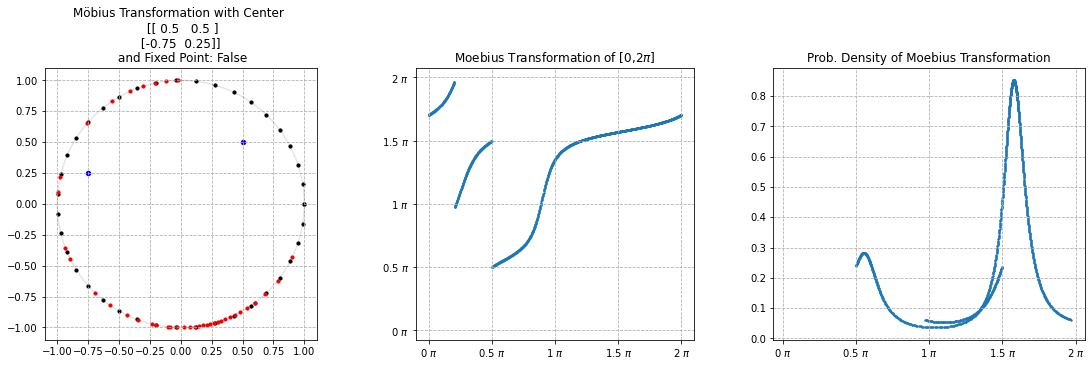

In [14]:
w1 = np.array([0.5,0.5])
w2 = np.array([0.75,0])
w3 = np.array([0,0.9])
w4 = np.array([-0.5,-0.5])
w5 = np.array([-0.75,0.25])

w = np.array([w1,w2,w3,w4,w5])

w = np.array([w1,w5])

rho = np.ones(w.shape[0])

plot_convex_moebius_transform(w, rho=rho, rotate_back=False, plot_name='Moeb_convex_wo_fix')


### Random convex combination

  5%|▌         | 51/1000 [00:00<00:03, 255.76it/s]

first theta tensor(0., dtype=torch.float64, grad_fn=<AddBackward0>)


100%|██████████| 1000/1000 [00:04<00:00, 241.49it/s]


last theta tensor(0., dtype=torch.float64, grad_fn=<AddBackward0>)


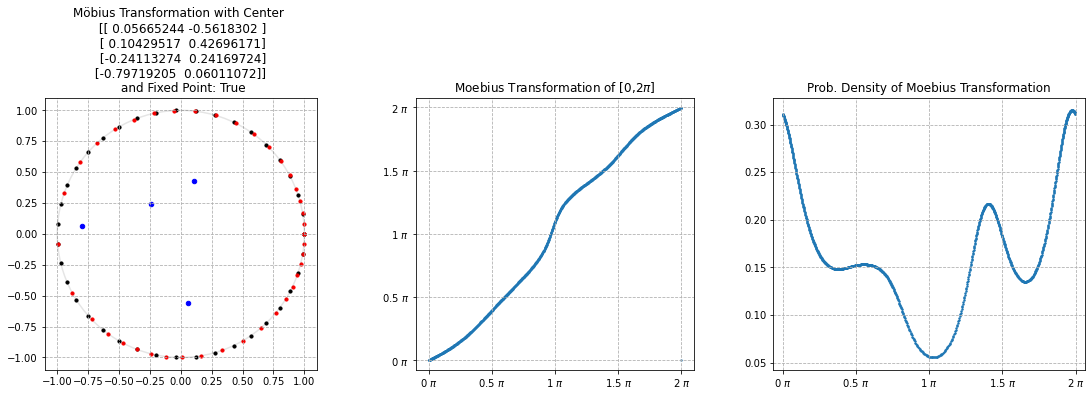

In [15]:
# from random import random
nr_transformations = 4
w = np.empty((nr_transformations,2))

for index in range(nr_transformations):
    phi = random()*2*np.pi
    r0 = random()*(0.95-0.1)+0.1
    w1 = r0*np.cos(phi)
    w2 = r0*np.sin(phi)

    w[index,:] = np.array([w1,w2])

plot_convex_moebius_transform(w,rho=np.ones(nr_transformations),rotate_back=True)


# invert Möbius flow via bisection search

In [16]:
from scipy.optimize import bisect

y = np.pi
w1 = np.array([0.5,0.5])
w2 = np.array([0.75,0])
w3 = np.array([0,0.9])
w4 = np.array([-0.5,-0.5])
w5 = np.array([-0.75,0.25])

w = np.array([w1,w2,w3,w4,w5])
rho = np.ones(w.shape[0])

def convex_wrapper(theta):
    """
    Wrapper function for bisection search. 
    Finds for given y an x such that f(x) = y via finding the root of g(z) = f(z) - y
    """
#     print(f'find root of {y}')
    return f_convex_moebius_transform(theta,w,rho,rotate_back=True) - y

In [17]:
# xtol is precision parameter that is usually set to 10^{-12}

# blubb = np.linspace(0, 2*np.pi, 100)

# NOTE: Inversion works for all kinds of values
y = 2
    
x_min = np.array([0])
x_max = np.array([2*np.pi-10e-5])
inverse = bisect(convex_wrapper,x_min, x_max ,xtol = 10e-8)

print('invere',inverse)
print('original value',f_convex_moebius_transform(inverse,w,rho,rotate_back=True))
print('original value-original value',f_convex_moebius_transform(inverse,w,rho,rotate_back=True)-y)

invere 1.509216739657162
original value [1.99999994]
original value-original value [-5.85640825e-08]


## Analytical Jacobian

define $ f(\theta) = \left(T_{z\to \theta} \circ h_\omega \circ T_{\theta \to z} \right)\left(\theta\right)$

$$ T_{z\to \theta} = T_2$$
$$ T_{\theta \to z} = T_1$$

# 1 dim implementation numpy

In [18]:
# Works only for dim = 2
from numpy.linalg import norm
from numpy.linalg import multi_dot

# NOTE: Did this only for dim = 2 because of the transformation T1 and T2. 
# Otherwise have to check how polar coordinate transformation works in R^d

def T_1(theta):
    return np.array([[ np.cos(theta),
                       np.sin(theta) ]]).T

    
def pder_T_1(theta):
    
    """
    Args:
        z column vector shape (2, 1)
        w column vector shape (n_dim, 1)
        
    Return:
        
    """
    return np.array([[ - np.sin(theta),
                         np.cos(theta)]]).T

def pder_T_2(h):
    """
    Args:
        h column vector shape (,2, 1)
            
    Return:  
        Grad_{x,y} arctan2(y,x) = (-y,x) 
        shape (1,2)
            
    """
    # transpose the non batch dimensions
#     print('norm of h',norm(h))
    return np.array([-h[1,0],h[0,0]])
    
    
def pder_h(z,w):
    
    """
    Args:
        z column vector shape (2, 1)
        w column vector shape (2, 1)
    Return 
        d h / d z = 
    """
    # z-w shape (batch,2,1)
    # z.T shape (batch,1,2)
    
    # norm( .. , axis = (1,2) ) ensures that norm is calculated per batch. is of shape (batch,)
    
    # einsum corresponds to np.dot(z-w,z.T) batchwise. result is of shape (batch,2,2)
    matrix = np.dot(z-w,(z-w).T)
#     print('matrix',matrix.shape)
    # prefactor is norm per batch and of shape (batch,)
    
    prefactor = -2 * (1-norm(w)**2) / norm(z-w)**4
    
    summand_one = prefactor*matrix
       
#     print('one',summand_one.shape)

    summand_two = ( (1 - norm(w)**2) / norm(z-w)**2 ) * np.identity(2)
    
#     print('two',summand_two.shape)
    return summand_one + summand_two 

def h(z,w):
    p = ( 1 - norm(w)**2 ) / norm(z-w)**2
    q = (z-w)
    return p*q - ww

    
def jacobian_f(theta,w):

    """
        calculate the product per batch of

        dT2/dh * dh/dT1 * dT1/dtheta . is of shape (1,2) (2,2) (2,1) 
        
    Args:
        theta shape (1,)
        w shape (2,1)
    Returns:
        f'(theta) shape (batch,)
    """

    z = T_1(theta)
    
    dT2_dh = pder_T_2( h(z,w) ) # shape (1,2)
     
    dh_dT1 = pder_h(z,w) # shape (1,2)
    
    dT1_dtheta = pder_T_1(theta) # shape (2,1)

    return multi_dot([dT2_dh,dh_dT1,dT1_dtheta])
    


## 1 dim Torch jacobian implementation

In [19]:
# Works only for dim = 2

r = 1

def T_1(theta):
    """
    Args:
        theta (1,)
    Return
        (2,)
    """

    return torch.stack([r * torch.cos(theta), r * torch.sin(theta)]).reshape(2,1)
#     return torch.stack([ torch.cos(theta),torch.sin(theta)]).reshape(2,1)

    
def pder_T_1(theta):
    
    """
    Args:
        z column vector shape (2, 1)
        
    Return:
        part derivative of T1. shape (2,1) is col vector
        
    """
    return torch.stack([- r * torch.sin(theta), r * torch.cos(theta)]).reshape(2,1)
#     return torch.stack([-  torch.sin(theta), torch.cos(theta)]).reshape(2,1)


def pder_T_2(h,r):
    """
    Args:
        h column vector shape (2, 1)
            
    Return:  
        Grad_{x,y} arctan2(y,x) = (-y,x) 
        shape (1,2)
            
    """
    # transpose the non batch dimensions
#     print('norm of h',norm(h))

    return 1/r ** 2 * torch.stack([-h[1], h[0]]).reshape(1,2)
    
    
def pder_h(z,w):
    
    """
    Args:
        z column vector shape (2, 1)
        w column vector shape (2, 1)
    Return 
        d h / d z = 
    """
    # NOTE: this r is for debugging
    
    # col vector times row vector = 2x2 matrix 
    matrix = torch.mm((z-w),(z-w).T)
    
    prefactor = - 2 * (r**2-torch.norm(w,2)**2) / torch.norm(z-w,2)**4
    
    summand_one = prefactor*matrix
       
    summand_two = ( (r**2 - torch.norm(w,2)**2) / torch.norm(z-w,2)**2 ) * torch.eye(2)
    
    return (summand_one + summand_two)


def h(z,w):

    p = (r ** 2 - torch.norm(w,2) ** 2) / torch.norm(z-w,2) ** 2
    q = (z-w)
    return p * q - w

    
def jacobian_f_torch(theta,w):
# def jacobian_f_torch(theta,w,Rotate_back_matrix):
    """
        calculate the product per batch of

        dT2/dh * dh/dT1 * dT1/dtheta . is of shape (1,2) (2,2) (2,1) 
        
    Args:
        theta torch tensor of size []
        w torch tensor of size [2,1]
    Returns:
        f'(theta) torch tensor [1]
    """

    z = T_1(theta)
    
#     dT2_dh = pder_T_2( Rotate_back_matrix @ h(z,w),r ) # shape (1,2)
    dT2_dh = pder_T_2( h(z,w), r) # shape (1,2)
     
    dh_dT1 = pder_h(z,w) # shape (1,2)
    
    dT1_dtheta = pder_T_1(theta) # shape (2,1)
    
    
    # Usually I very much dislike the @ operator but here it's appropriate I think due to chainings
    # Result is the same as with torch.mm (= matrix multiplication)
    # print(torch.mm(torch.mm(dT2_dh,dh_dT1),dT1_dtheta))  
    
    return (dT2_dh@dh_dT1@dT1_dtheta).view(1)


In [20]:
z =  torch.tensor([[ 1.0000e+00],[-2.4493e-16]])
w = torch.tensor([[0.7500],  [0.2000]])
theta = torch.tensor(np.pi/3)

jacobian_f_torch(theta,w)

tensor([0.7854])

$$ p(\theta') $$

## Evaluate likelihood with analytical and autograd jacobian 

In [23]:
rotate_back=True

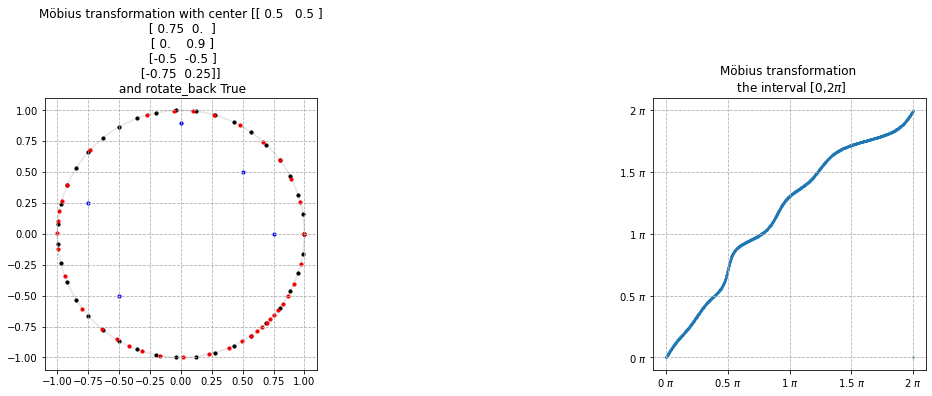

In [24]:
# def plot_convex_moebius_transform(w,rho,rotate_back=False):


w1 = np.array([0.5,0.5])
w2 = np.array([0.75,0])
w3 = np.array([0,0.9])
w4 = np.array([-0.5,-0.5])
w5 = np.array([-0.75,0.25])
w = np.array([w5])
w = np.array([w1,w2,w3,w4,w5])

rho = np.ones(w.shape[0])

# w = w.reshape(1,2)



"""
    Args: list of centers of shape (K_m, nr_dim)

    Return: plots
"""
nr_points = 40

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2,  figsize=(20,5))

# Plot circle
theta = np.linspace(0, 2*np.pi, 100)

r = np.sqrt(1.0)
x1 = r*np.cos(theta)
x2 = r*np.sin(theta)

ax1.plot(x1, x2,color ='black',alpha = 0.1)

# plot equidistant points on circle
theta = np.linspace(0, 2*np.pi, nr_points)
x1s = r*np.cos(theta)
x2s = r*np.sin(theta)
ax1.scatter(x1s, x2s,s= 10, color ='black',alpha = 1)

# plot parameter points
for center in w:
    ax1.scatter(center[0],center[1],s= 10, color ='blue',alpha = 1)

# plot möbius transform
theta = f_convex_moebius_transform(theta,w,rho,rotate_back=rotate_back)

r = np.sqrt(1.0)
x1 = r*np.cos(theta)
x2 = r*np.sin(theta)

ax1.scatter(x1, x2,s= 10, color ='red',alpha = 1)

ax1.grid(linestyle='--')
ax1.title.set_text(f'Möbius transformation with center {w} \n and rotate_back {rotate_back}')

# PLOT 2: 
# Möbius transformation of the interval [0,2pi] plot
theta0 = np.linspace(0, 2*np.pi, 1000)
f_theta = f_convex_moebius_transform(theta0,w,rho,rotate_back=rotate_back) 

ax2.scatter(theta0/np.pi,f_theta/np.pi,s=2)
ax2.grid(linestyle='--')
ax2.title.set_text(f'Möbius transformation \n the interval [0,2$\pi$]')

ax1.set(aspect='equal')
ax2.set(aspect='equal')

# add ticks at multiples of pie
ax2.xaxis.set_major_formatter(tck.FormatStrFormatter('%g $\pi$'))
ax2.xaxis.set_major_locator(tck.MultipleLocator(base=1/2))
ax2.yaxis.set_major_formatter(tck.FormatStrFormatter('%g $\pi$'))
ax2.yaxis.set_major_locator(tck.MultipleLocator(base=1/2))


plt.show()

  2%|▏         | 22/1000 [00:00<00:04, 213.14it/s]

first theta tensor(0., dtype=torch.float64, grad_fn=<AddBackward0>)


  4%|▍         | 41/1000 [00:00<00:02, 400.48it/s]

last theta tensor(0., dtype=torch.float64, grad_fn=<AddBackward0>)


100%|██████████| 1000/1000 [00:01<00:00, 507.61it/s]


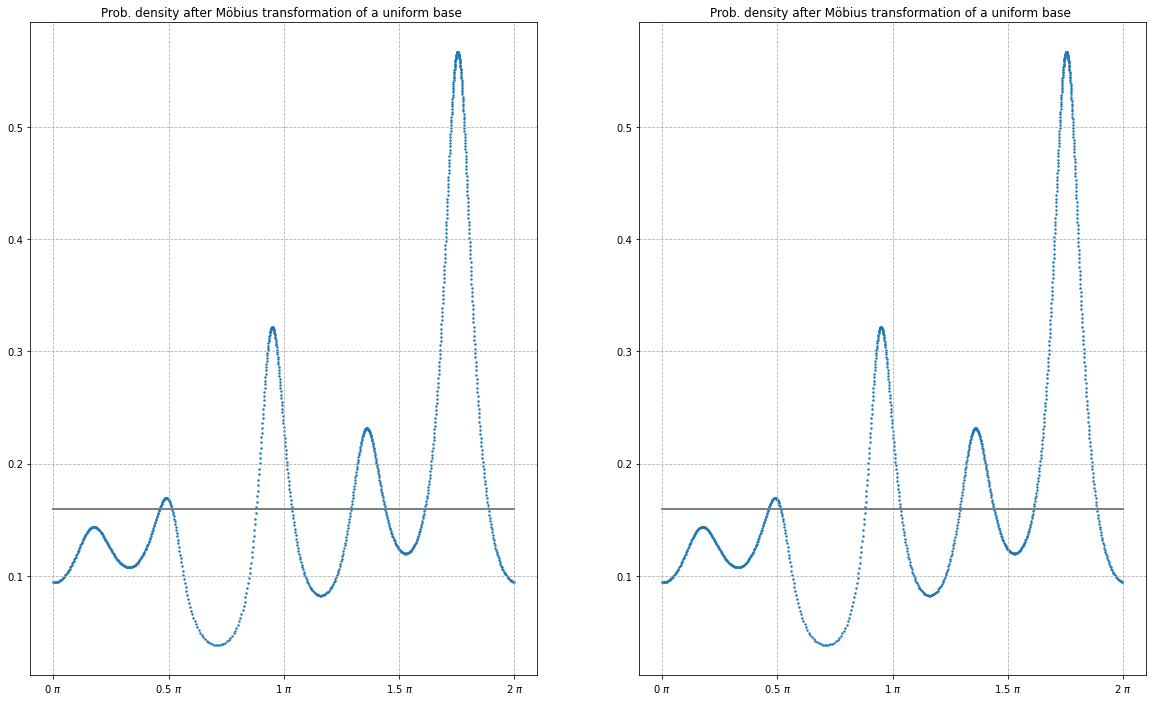

In [25]:

# PLOT 3 - density update
# Density plotstd
theta0s = torch.tensor(theta0, requires_grad=True)

# rotation_theta = get_angle_of_rotation(w)

w_torch = torch.tensor(w)
    
    
nr_transformations = w_torch.shape[0]
rho = np.ones(nr_transformations)

fig, (ax3,ax4) = plt.subplots(nrows=1, ncols =2,  figsize=(20,12))

i = 0 

for theta in tqdm(theta0s):
    f_theta_torch = f_convex_moebius_transform_torch(theta,w_torch,rho=rho,rotate_back=rotate_back)
    if i ==0:
        print('first theta',f_theta_torch)
    if i == (len(theta0s)-1):
        print('last theta',f_theta_torch)
    i = i +1
    f_theta_torch.backward()

Jacobian_f = theta0s.grad.detach().numpy()


# change of variables formula: 
#    p(x) = p_0(f^{-1}(x)) * J_f^{-1}(theta)
# or p(f(theta)) = p_0 (theta) / J_(theta) ! We use this version, because we can not analytically obtain f^{-1} in the convex case



ax3.scatter( f_theta/np.pi, 1 / (2 * np.pi * Jacobian_f) , s = 2)             
ax3.plot( theta0/np.pi  , [1 / (2 * np.pi) for _ in range(len(theta0))]  ,linewidth=2,color = 'grey')
# ax3.set(aspect='equal')

ax3.grid(linestyle='--')
ax3.title.set_text(f'Prob. density after Möbius transformation of a uniform base ')


ax3.xaxis.set_major_formatter(tck.FormatStrFormatter('%g $\pi$'))
ax3.xaxis.set_major_locator(tck.MultipleLocator(base=1/2)) 



# rcParams['figure.figsize'] = 12, 12

Jacobian_f_analy = []

theta0s = theta0s.detach()

# w_torch = torch.tensor([0.75,0.2]).view(1,2)
# nr_transformations = 1
  
for theta in tqdm(theta0s):
    
    jacobian_f0 = 0 
    
    for w0 in w_torch:
#         print(w0)
#         print(w0)
        
        jacobian_f0 += jacobian_f_torch(theta,w0.view(2,1))[0].detach().numpy()

    Jacobian_f_analy.append(1/nr_transformations * jacobian_f0)
    
Jacobian_f_analy = np.array(Jacobian_f_analy)


ax4.scatter( f_theta/np.pi, 1/(2 * np.pi * Jacobian_f_analy) , s = 2)     

ax4.plot( theta0/np.pi , [1 / (2 * np.pi) for _ in range(len(theta0))]  ,linewidth=2,color = 'grey')


ax4.grid(linestyle='--')
ax4.title.set_text(f'Prob. density after Möbius transformation of a uniform base ')


ax4.xaxis.set_major_formatter(tck.FormatStrFormatter('%g $\pi$'))
ax4.xaxis.set_major_locator(tck.MultipleLocator(base=1/2)) 